In [1]:
import numpy as np
from math import pi
import astropy.units as u
from astropy.constants import h,k_B, c, m_e, N_A
import matplotlib.pyplot as plt
from scipy.special import kn, iv
import pdb

np.set_printoptions(precision=4)
verbose = True
datatype = u.quantity.Quantity

%matplotlib inline

In [2]:
def niceprint(*args):
    print(*("{0:0.4f}".format(a) if isinstance(a, datatype) or\
        isinstance(a, float) else a for a in args))

K_0 = lambda x: kn(0, x)
I_0 = lambda x: iv(0, x)

hbar = h/(2*np.pi)
dB = u.dB(1)
dBm = u.dB(u.mW)

# Resonator Parameters
gamma_s = 1
Q_int = 3e8

T_amp = 5.22 * u.Kelvin
eta_read = 0.1

P_opt = 4.00*u.pW
P_g = (-100*dBm).to(u.pW)

gamma_leg = 2.86 # conductivity index = beta + 1
K_leg = 122 * u.picoWatt/u.Kelvin**gamma_leg
T_c = 1.329 * u.Kelvin
T_0 = 0.086 * u.Kelvin # Previously 0.23K Temperature of the thermal bath

gamma = 1.35 * u.mJ/u.mol/u.Kelvin**2
density = 2.7 * u.g/u.cm**3
A_r = 26.98 * u.g/u.mol
rho = 1.15 * u.uOhm * u.cm

Delta = (1.764 * k_B * T_c).to('J')

# Physical properties of the superconductor + resonator capacitor
t = 0.05 * u.um
w_trace = 1 * u.um #width of inductor trace
s_trace = 1 * u.um #spacing between inductor meanders
N_sq = 16200  # Number of squares
l = N_sq * w_trace # Total length of the inductor (approximately. More exact is +21um + ...)
A = t * w_trace # cross-sectional area
V_sc = l * A
L_g = 6.1 * u.nH # From simulations

Rs = (rho/t).to('Ohm') # surface resistance in ohms/sq
L_k = (h * Rs/(2 * np.pi**2 * Delta) * N_sq).to('nH') # Kinetic inductance contribution
Z0 = 50 * u.Ohm # Characteristic impedance of the line

In [3]:
rs = np.r_[0.1:10.0:1000j]*u.um**3/u.s
tmxs = np.r_[100:1000:1000j]*u.us

tau_max, R = np.meshgrid(tmxs, rs)
n_qp_star = (1./(R*tau_max)).to(1./u.um**3)

n_bg = 627/u.um**3

In [4]:
f_r = 337.4 * u.MHz
f_g = f_r
P_total = 0.5 * P_g + P_opt
T_b= (((P_total/K_leg).value + T_0.value**gamma_leg)**(1./gamma_leg))*u.Kelvin
niceprint("The temperature of the island", T_b)

L = L_g + L_k # total inductance
alpha = (L_k/L).to(1)
if verbose: niceprint ("The total inductance", L)

omega_r = (2*np.pi*f_r).to(1/u.s)

eta = (h * f_g / (2*k_B * T_b)).to(1).value 
S_1 = ((2/np.pi)*np.sqrt(2*Delta/(np.pi*k_B*T_b))*np.sinh(eta * u.rad)*K_0(eta)).to(1)
S_2 = (1 + np.sqrt(2*Delta/(np.pi*k_B*T_b)) * np.exp(-eta) * I_0(eta)).to(1)
# niceprint (S_1, S_2)
beta = S_2/S_1

N_0 = ((3 * (gamma * (density/A_r)))/(2*np.pi**2 * k_B**2)).to('1/(J um^3)')
Gamma_gen = (eta_read * P_g/Delta).to('1/s')
n_th = (2*N_0 * np.sqrt(2*np.pi* k_B * T_b* Delta)*np.exp(-Delta/(k_B*T_b))).to('1/um^3')
niceprint ("Quasiparticle parameters calculated.\n")

# Quality factors
Gamma_th = ((n_th * V_sc/tau_max)* (1 + 0.5 * n_th/n_qp_star)).to('1/s')
n_qp = (np.sqrt((n_th + n_qp_star)**2 + n_bg**2) - n_qp_star).to('1/um^3')
tau_qp = (1./(1./tau_max + R*n_qp)).to('us')

kappa = (0.5 + Delta/(k_B*T_b)).to(1)
G_b = (gamma_leg*K_leg*T_b**(gamma_leg - 1)).to(u.pW/u.Kelvin)



The temperature of the island 0.3069 K
The total inductance 9.9642 nH
Quasiparticle parameters calculated.



In [5]:
NEP_gr = ((2*G_b*T_b/kappa)*np.sqrt((tau_qp/(n_qp*V_sc))*(1 + tau_qp/tau_max))).to(u.aW/u.Hz**0.5)
f3dB = (1./(pi*tau_qp)).to(u.kHz)

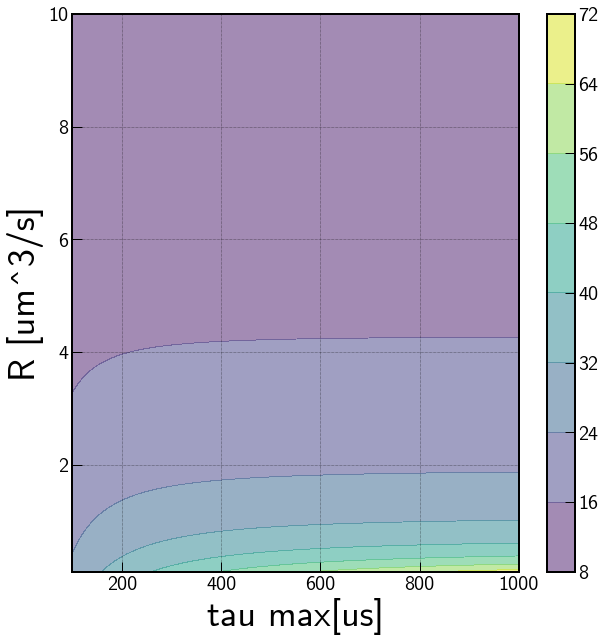

In [6]:
plt.figure(figsize=(10,10))
plt.contourf(tau_max.value, R.value, NEP_gr, alpha=0.5)
plt.xlabel('tau max[us]')
plt.ylabel('R [um^3/s]')
plt.colorbar()
plt.grid()

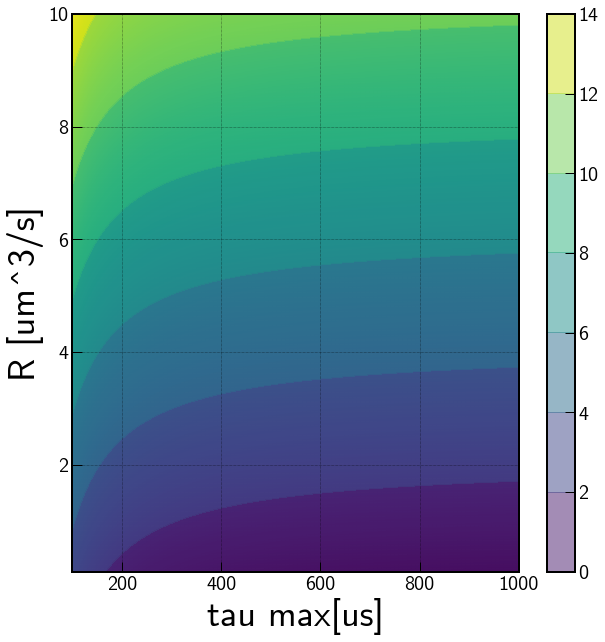

In [7]:
plt.figure(figsize=(10,10))
plt.pcolormesh(tau_max.value, R.value, f3dB, alpha=0.5)
plt.contourf(tau_max.value, R.value, f3dB, alpha=0.5)
plt.xlabel('tau max[us]')
plt.ylabel('R [um^3/s]')
plt.colorbar()
plt.grid()

Want to reverse the problem and see how to access various values of R and tau max based on measured NEPs and lifetimes

In [13]:
f_r = 337.4 * u.MHz
f_g = f_r
P_opt = 10.0*u.pW

P_total = 0.5 * P_g + P_opt
T_b= (((P_total/K_leg).value + T_0.value**gamma_leg)**(1./gamma_leg))*u.Kelvin
niceprint("The temperature of the island", T_b)

L = L_g + L_k # total inductance
alpha = (L_k/L).to(1)
if verbose: niceprint ("The total inductance", L)

omega_r = (2*np.pi*f_r).to(1/u.s)

eta = (h * f_g / (2*k_B * T_b)).to(1).value 
S_1 = ((2/np.pi)*np.sqrt(2*Delta/(np.pi*k_B*T_b))*np.sinh(eta * u.rad)*K_0(eta)).to(1)
S_2 = (1 + np.sqrt(2*Delta/(np.pi*k_B*T_b)) * np.exp(-eta) * I_0(eta)).to(1)
# niceprint (S_1, S_2)
beta = S_2/S_1

N_0 = ((3 * (gamma * (density/A_r)))/(2*np.pi**2 * k_B**2)).to('1/(J um^3)')
Gamma_gen = (eta_read * P_g/Delta).to('1/s')
n_th = (2*N_0 * np.sqrt(2*np.pi* k_B * T_b* Delta)*np.exp(-Delta/(k_B*T_b))).to('1/um^3')
niceprint ("Quasiparticle parameters calculated.\n")

# Quality factors
# Gamma_th = ((n_th * V_sc/tau_max)* (1 + 0.5 * n_th/n_qp_star)).to('1/s')
# n_qp = (np.sqrt((n_th + n_qp_star)**2 + (2*Gamma_gen*n_qp_star*tau_max/V_sc)) - n_qp_star).to('1/um^3')
n_qp = (np.sqrt((n_th + n_qp_star)**2 + n_bg**2) - n_qp_star).to('1/um^3')
tau_qp = (1./(1./tau_max + R*n_qp)).to('us')

kappa = (0.5 + Delta/(k_B*T_b)).to(1)
G_b = (gamma_leg*K_leg*T_b**(gamma_leg - 1)).to(u.pW/u.Kelvin)

limit = np.sqrt(((2*G_b*T_b)/kappa)**2/(n_qp*V_sc)).to(u.aW)
print (limit)

The temperature of the island 0.4193 K
The total inductance 9.9642 nH
Quasiparticle parameters calculated.

[[2018.2015 2018.2011 2018.2007 ... 2018.0667 2018.0667 2018.0666]
 [2018.1972 2018.1968 2018.1964 ... 2018.062  2018.062  2018.0619]
 [2018.1931 2018.1927 2018.1922 ... 2018.0579 2018.0579 2018.0578]
 ...
 [2018.0065 2018.0064 2018.0063 ... 2017.9983 2017.9983 2017.9983]
 [2018.0065 2018.0064 2018.0063 ... 2017.9983 2017.9983 2017.9983]
 [2018.0064 2018.0064 2018.0063 ... 2017.9983 2017.9983 2017.9983]] aW


In [14]:
neps = np.r_[1:100:1000j]*u.aW/u.Hz**0.5
fs = np.r_[10:1000:1000j]*u.Hz

f3dBs, NEP_grs = np.meshgrid(fs, neps)

R = ((pi*f3dBs/n_qp)*(2 - ((kappa/(2*G_b*T_b))**2*n_qp*V_sc*pi*f3dBs*NEP_grs**2))).to(u.um**3/u.s)
tau_max = (1./(pi*f3dBs - R*n_qp)).to(u.us)

mask = np.logical_or(R < 0, tau_max < 0)
tau_max[mask] = np.nan
R[mask] = np.nan

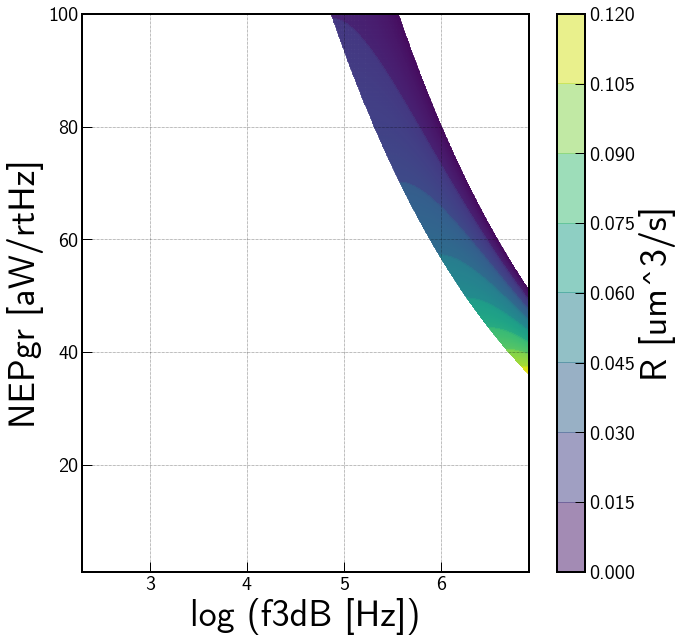

In [15]:
plt.figure(figsize=(10,10))
plt.pcolormesh(np.log(f3dBs.value), NEP_grs.value, R.value, alpha=0.5)
plt.contourf(np.log(f3dBs.value), NEP_grs.value, R.value, alpha=0.5)
plt.xlabel('log (f3dB [Hz])')
plt.ylabel('NEPgr [aW/rtHz]')
plt.colorbar(label='R [um^3/s]')
plt.grid()

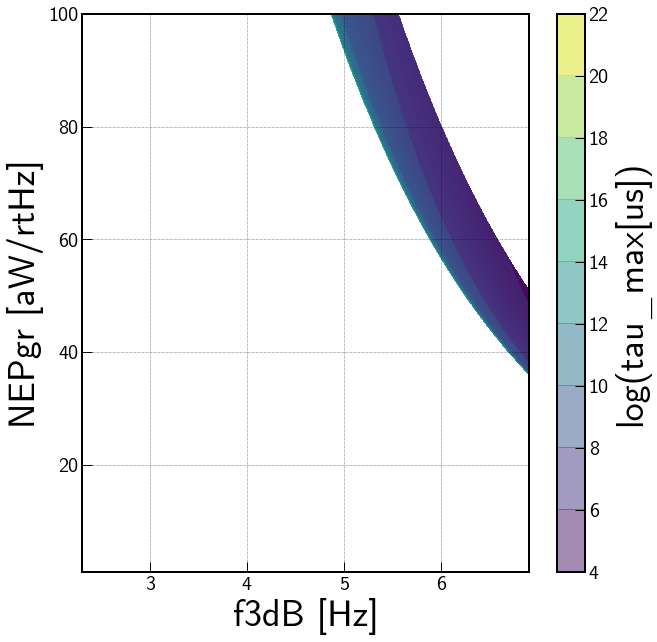

In [16]:
plt.figure(figsize=(10,10))
plt.pcolormesh(np.log(f3dBs.value), NEP_grs.value, np.log(tau_max.value), alpha=0.5)
plt.contourf(np.log(f3dBs.value), NEP_grs.value, np.log(tau_max.value), alpha=0.5)
plt.xlabel('f3dB [Hz]')
plt.ylabel('NEPgr [aW/rtHz]')
plt.colorbar(label='log(tau_max[us])')
plt.grid()

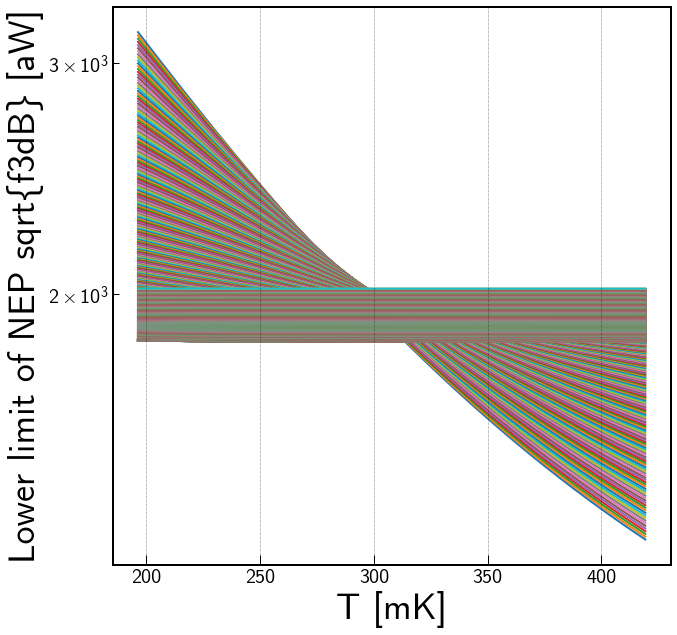

In [17]:
f_r = 337.4 * u.MHz
f_g = f_r
P_opt = np.r_[1:10.0:1000j]*u.pW

P_total = 0.5 * P_g + P_opt
T_b= (((P_total/K_leg).value + T_0.value**gamma_leg)**(1./gamma_leg))*u.Kelvin

L = L_g + L_k # total inductance
alpha = (L_k/L).to(1)

omega_r = (2*np.pi*f_r).to(1/u.s)

eta = (h * f_g / (2*k_B * T_b)).to(1).value 
S_1 = ((2/np.pi)*np.sqrt(2*Delta/(np.pi*k_B*T_b))*np.sinh(eta * u.rad)*K_0(eta)).to(1)
S_2 = (1 + np.sqrt(2*Delta/(np.pi*k_B*T_b)) * np.exp(-eta) * I_0(eta)).to(1)
beta = S_2/S_1

N_0 = ((3 * (gamma * (density/A_r)))/(2*np.pi**2 * k_B**2)).to('1/(J um^3)')
Gamma_gen = (eta_read * P_g/Delta).to('1/s')
n_th = (2*N_0 * np.sqrt(2*np.pi* k_B * T_b* Delta)*np.exp(-Delta/(k_B*T_b))).to('1/um^3')

# Quality factors
# Gamma_th = ((n_th * V_sc/tau_max)* (1 + 0.5 * n_th/n_qp_star)).to('1/s')
# n_qp = (np.sqrt((n_th + n_qp_star)**2 + (2*Gamma_gen*n_qp_star*tau_max/V_sc)) - n_qp_star).to('1/um^3')
n_qp = (np.sqrt((n_th + n_qp_star)**2 + n_bg**2) - n_qp_star).to('1/um^3')
tau_qp = (1./(1./tau_max + R*n_qp)).to('us')

kappa = (0.5 + Delta/(k_B*T_b)).to(1)
G_b = (gamma_leg*K_leg*T_b**(gamma_leg - 1)).to(u.pW/u.Kelvin)

limit = np.sqrt(((2*G_b*T_b)/kappa)**2/(n_qp*V_sc)).to(u.aW)


plt.figure(figsize=(10,10))
plt.semilogy(T_b.to(u.mK).value, limit.value)
plt.grid()
# plt.xlabel('Popt [pW]')
plt.xlabel('T [mK]')
plt.ylabel('Lower limit of NEP sqrt{f3dB} [aW]');
